In [2]:
### run the script from the figures_code directory
import os
import sys
os.chdir('../')
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
from functions import data_processing as dp
from functions import lib_table_operations as lto
from functions import general_functions as gf
from functions import params
import warnings
from matplotlib.patches import Rectangle
from collections import OrderedDict

warnings.simplefilter(action='ignore', category=FutureWarning)

## (B) - H3 wild-type sequence fold change

(-0.15, 1.5)

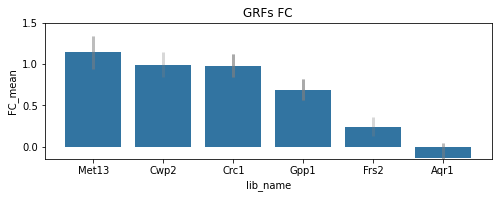

In [30]:
grfs = ['Reb1', 'Abf1', 'Rap1']
exp_num = '29'
tp = '180'
# grf_libs = np.unique([file.split('_')[1] for file in os.listdir(params.RES_PATH) if file.split('_')[0] in grfs]) # get GRFs library numbers
grfs_libs_fc = pd.DataFrame()

for tf in grfs: # iterate over GRFs
    tf_libs = [f.split('_')[1] for f in dp.find_tf_files(tf)] # get GRF library numbers
    for lib_i, lib_num in enumerate(tf_libs): # iterate over GRF library numbers
        lib_info = dp.get_lib_info(lib_num) # get library information
        gene = lib_info['gene'].upper() # get library gene name
        wt_var_seq = ''.join(lib_info['wt_at_var_loc']) # get library wild type sequence
        mut_var_seq = lto.get_mut_var(lib_num) # get library fully mutated sequence
        norm_tp_0 = lto.norm_without_biorep_mean('H3', lib_num, exp_num, 0, occ=None) # normlize data
        norm_tp = norm_tp_0[norm_tp_0.columns[norm_tp_0.columns.str.contains(tp)]] # get relevant time point
        h3_fc = norm_tp.loc[wt_var_seq] - norm_tp.loc[mut_var_seq] # calculate fold change
        h3_mean_fc = h3_fc.mean() # mean fold change
        h3_sem_fc = h3_fc.sem() # fold change std
        h3_lib_fc = pd.DataFrame({"Lib":[lib_num],'FC_mean':[h3_mean_fc], # save data
                                  'FC_sem':[h3_sem_fc],'Dataset':['H3'], 'lib_name':[lib_info['gene']]})
        h3_lib_fc.set_index('Lib',inplace=True)
        grfs_libs_fc = pd.concat([grfs_libs_fc,h3_lib_fc])

f, curr_ax = plt.subplots(1,1,figsize=(8,2.5))
grfs_libs_fc = grfs_libs_fc.sort_values(by='FC_mean', ascending=False)
sns.barplot(data=grfs_libs_fc, x='lib_name', y='FC_mean', ax=curr_ax)
curr_ax.errorbar(data=grfs_libs_fc, x='lib_name', y='FC_mean',yerr='FC_sem',
                 ls='', lw=3, color='grey', alpha=0.3)
curr_ax.set_title('GRFs FC')
curr_ax.set_ylim(-0.15, 1.5)

## (C) CRC1 library H3 vs Reb1

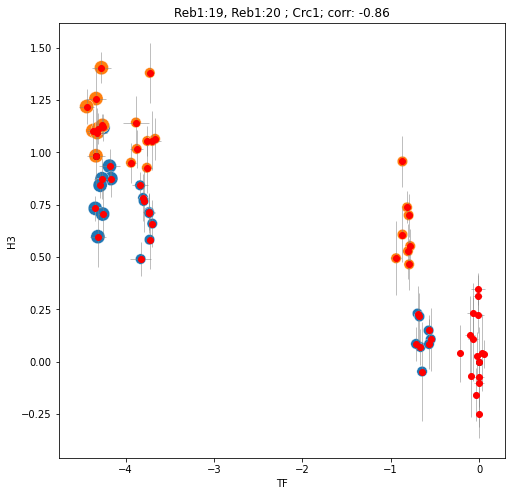

In [31]:
tf='Reb1'
color_tf = 'Abf1'
lib_tfs = ['Reb1', 'Abf1']
tp='180'
lib_num = '76'
exp_num_h3 = '29'
exp_num_tf = '16'
lib_info = dp.get_lib_info(lib_num)
gene = lib_info['gene'].upper()
wt_var_seq = ''.join(lib_info['wt_at_var_loc'])
mut_var_seq = lto.get_mut_var(lib_num)
fig, curr_ax = plt.subplots(1, 1, figsize=(8,8))

# normlize nucs
norm_uncut_h3 = lto.norm_without_biorep_mean('H3', lib_num, exp_num_h3, None, occ=None) # normlize data
mean_res_h3 = dp.mean_over_bio_reps(norm_uncut_h3)[tp]      ##################
sem_h3 = dp.sem_over_bio_reps(norm_uncut_h3)[tp]

#normzlize tf
norm_uncut_tf = lto.norm_without_biorep_mean(tf, lib_num, exp_num_tf, None, occ=None) # normlize data
mean_res_tf = dp.mean_over_bio_reps(norm_uncut_tf)[tp]      ##################
sem_tf = dp.sem_over_bio_reps(norm_uncut_tf)[tp]

#combine H3 and TF data to df
exp_comp_df = pd.concat([mean_res_tf, mean_res_h3],axis=1)
exp_comp_df.columns = ['TF', 'H3'] 
exp_comp_df['H3_sem'] = sem_h3
exp_comp_df['TF_sem'] = sem_tf

# get TF motif ranks within libraries
tf_ranks=[]
lib_int = int(lib_num)
for i, row in params.LIB_MOT_RANK.query("lib==@lib_int and tf==@tf").iterrows():
    tf_ranks.append(row['tf'] + ':' + str(i))
', '.join(tf_ranks)

corr_val = str(np.round(exp_comp_df.corr().values[1][0],2)) #correlation between TF and H3

#### scatters comparing plasmid to Nucleosome

seqs = exp_comp_df.index # library sequences
all_seqs_split = np.array([list(seq) for seq in seqs]) # library sequences splited
tf_intact_motif_seqs = np.zeros((len(seqs),len(lib_tfs))) 
for tf_i, curr_tf in enumerate(lib_tfs): # iterate over tfs
    tf_pos = lto.get_tf_mot_pos(curr_tf,lib_num) #get tf library positions
    for pos in tf_pos:#iterate over tf postion
        tf_intact_motif_seqs[all_seqs_split[:,pos]==wt_var_seq[pos], tf_i] += 1 # count number of tf motif in seq
exp_comp_df[lib_tfs] = tf_intact_motif_seqs 

sns.scatterplot(data=exp_comp_df, x='TF', y='H3', hue='Abf1',
                size='Reb1',sizes=(20,200), ax=curr_ax)
curr_ax.errorbar(exp_comp_df['TF'], exp_comp_df['H3'], xerr=exp_comp_df['TF_sem'],
             yerr=exp_comp_df['H3_sem'],ecolor='grey',elinewidth=0.5, color='r', fmt='o')

plt.scatter(x=exp_comp_df['TF'].loc[wt_var_seq], y=exp_comp_df['H3'].loc[wt_var_seq], color='k')
plt.scatter(x=exp_comp_df['TF'].loc[mut_var_seq], y=exp_comp_df['H3'].loc[mut_var_seq], color='k')


curr_ax.set_title(', '.join(tf_ranks) + ' ; ' + lib_info['gene'] + '; corr: ' + corr_val)
curr_ax.get_legend().remove()

## (D) Kaplan GRF motif meta_profiles

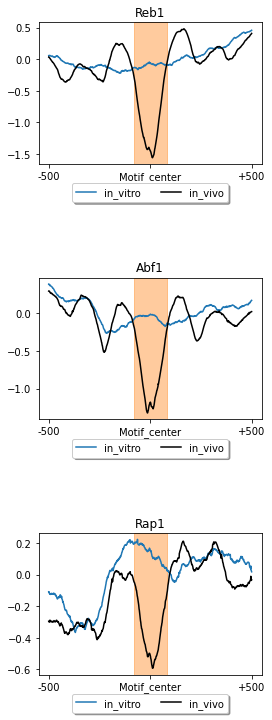

In [32]:
grfs = ['Reb1', 'Abf1', 'Rap1']
group_size = 200
edge = 500
lib_len = 164
fig, axes = plt.subplots(3,1,figsize=(4,12))
plt.subplots_adjust(hspace = 0.8)

for tf_i, tf in enumerate(grfs):# iterate over GRFs
    tf_df = params.MOT_GENOMIC_DATA.query("tf==@tf") # get tf motifs in promoter data
    tf_df = tf_df.drop_duplicates(['chr_num','mot_start_i']) # remove bidirecional promoter motifs
    tf_sorted_df = tf_df.sort_values(by='ChEC', ascending=False) # Sort motif by binding score
    curr_group_data = tf_sorted_df.iloc[0:group_size] # get top motifs
    
    in_vitro_mean = np.empty((group_size,edge*2))
    in_vivo_mean = np.empty((group_size,edge*2))
    for row_i in range(group_size): # iterate over motifs
        curr_row = curr_group_data.iloc[row_i,:] # mot data
        mot_center = curr_row['mot_start_i'] + int(np.round(len(curr_row['mot_seq'])/2)) # motif center pos
        in_vitro_signal = params.kaplan_in_vitro[curr_row['chr_num']][mot_center-edge:mot_center+edge].values # kaplan motif region in vitro
        in_vivo_signal= params.kaplan_in_vivo[curr_row['chr_num']][mot_center-edge:mot_center+edge].values # kaplan motif region in vivo
        if curr_row['mot_direction' ] == 0: # convert signal to correct orientation
            in_vitro_signal = np.flip(in_vitro_signal)
            in_vivo_signal = np.flip(in_vivo_signal)
        in_vitro_mean[row_i,:] = in_vitro_signal # mean over 200 top motif region dignal within promoters
        in_vivo_mean[row_i,:] = in_vivo_signal
           
        
    curr_ax = axes.ravel()[tf_i]
    sns.lineplot(x=range(edge*2),y=np.nanmean(in_vitro_mean,axis=0), label='in_vitro', ax=curr_ax)
    sns.lineplot(x=range(edge*2),y=np.nanmean(in_vivo_mean,axis=0), label='in_vivo',
                 color='k', ax=curr_ax)
    curr_ax.set_xticks(np.arange(0,edge*2+1,edge), labels=['-500', 'Motif_center', '+500'])
    curr_ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                   fancybox=True, shadow=True, ncol=2)
    y_lim = curr_ax.get_ylim()
    curr_ax.add_patch(Rectangle((edge-lib_len/2, y_lim[0]), lib_len,
                                abs(y_lim[0])+ abs(y_lim[1]), color='C1', alpha=0.4))    
    curr_ax.set_title(tf)

## (E) Kaplan mean FC

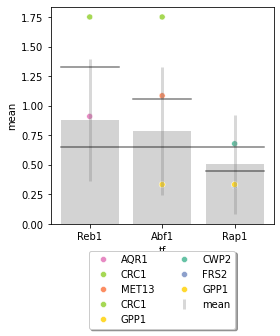

In [33]:
grfs = ['Reb1', 'Abf1','Rap1']

tf_signal_edge = 500
prom_len=1000
dataset = 'kaplan'
grf_libs = np.unique([file.split('_')[1] for file in os.listdir(params.RES_PATH) if file.split('_')[0] in grfs]) # get GRFs library numbers

grfs_libs_fc_kaplan = pd.DataFrame()
for lib_i, lib_num in enumerate(grf_libs): # iterate over GFF libraries   
    lib_info = dp.get_lib_info(lib_num) # get library info
    gene = lib_info['gene'].upper() # library gene
    curr_lib_locs = params.LIB_LOCS.loc[int(lib_num)] # library lovation in genome
    curr_chr = curr_lib_locs['Chromosome'] 
    lib_start_id = curr_lib_locs['Lib_start']
    lib_end_id = curr_lib_locs['Lib_end']
    lib_data_dict1 = params.kaplan_in_vitro[curr_chr][lib_start_id:lib_end_id] # library data in Kaplan dataset
    lib_data_dict2 = params.kaplan_in_vivo[curr_chr][lib_start_id:lib_end_id]
    curr_fc = lib_data_dict1 - lib_data_dict2 # clculate library fold change
    curr_fc_mean = np.mean(curr_fc)
    grfs_libs_fc_kaplan = pd.concat([grfs_libs_fc_kaplan, pd.DataFrame({'Dataset': dataset,'Gene':gene, 'Lib': [lib_num],
                                                          'FC': [curr_fc_mean]})])
group_sizes = 200
q_r = 95
q_l = 5

stat_grfs = pd.DataFrame()
fc_table = pd.DataFrame()
for tf_i, tf in enumerate(grfs): # iterate over GRFs
    tf_df = params.MOT_GENOMIC_DATA.query("tf==@tf") # get tf motifs in promoters
    tf_df = tf_df.drop_duplicates(['chr_num','mot_start_i']) # remove bidirectional promoters
    tf_sorted_df = tf_df.sort_values(by='ChEC', ascending=False) # sort by binding 
    group_data = tf_sorted_df.iloc[0:+group_size] # get top 200 motifs
    group_data = group_data['Segal_in_vitro']-group_data['Segal_in_vivo'] # clculate FC at motif region
    group_data = group_data.reset_index(drop=True).to_frame()
    group_data.columns = ['FC']
    group_data['TF'] = np.repeat(tf, group_size)
    group_data.dropna(inplace=True)
    row_inds = np.logical_and(group_data['FC'].values > np.percentile(group_data['FC'], q_l), # get 95 precentile of the distribution
                              group_data['FC'].values < np.percentile(group_data['FC'], q_r))
    group_data = group_data.iloc[row_inds,:]       
    fc_table = pd.concat([fc_table,group_data])
    fc_table.reset_index(drop=True, inplace=True)
    mean_df = group_data[['FC','TF']].groupby(['TF']).mean() # get distribution mean and std
    std_df = group_data[['FC','TF']].groupby(['TF']).std()
    stat_df = pd.concat([std_df,mean_df],axis=1)
    stat_df.columns = ['std', 'mean']
    stat_df['tf'] = [tf.split('_')[0]]
    stat_df['data'] = ['Kaplan']
    stat_grfs=pd.concat([stat_grfs,stat_df])

_,ax = plt.subplots(1,1,figsize=(4,4))
sns.barplot(data=stat_grfs, x='tf',y='mean',ax=ax, color='lightgrey')
ax.errorbar(data=stat_grfs, x='tf', y='mean', yerr='std', ls='', lw=3, color='grey', alpha=0.3)

libs_color_dict = gf.generate_color_dict(sns.color_palette("Set2",as_cmap=False),grfs_libs_fc_kaplan['Gene'], 1)                                       
                                         
for tf_i, tf in enumerate(grfs):
    tf_libs = [f.split('_')[1] for f in dp.find_tf_files(tf)]
    tf_fc = grfs_libs_fc_kaplan.query("Lib in @tf_libs")
    mean_tf_fc = tf_fc['FC'].mean()   
    sns.lineplot(x=[tf_i-0.4,tf_i+0.4], y=np.repeat(mean_tf_fc,2),color='k', alpha=0.5)
    sns.scatterplot(x=np.repeat(tf_i,tf_fc.shape[0]),y=tf_fc['FC'],hue=tf_fc['Gene'], palette=libs_color_dict, ax=ax)


mean_h3_fc = grfs_libs_fc.drop_duplicates()['FC_mean'].mean()

sns.lineplot(x=[-0.4,2.4], y=np.repeat(mean_h3_fc,2),color='k', alpha=0.5)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),fancybox=True, shadow=True, ncol=2)

## (H) - TF dependency on GRFs

/home/labs/barkailab/tamarj/.conda/envs/cobind/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/labs/barkailab/tamarj/.conda/envs/cobind/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/labs/barkailab/tamarj/.conda/envs/cobind/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/labs/barkailab/tamarj/.conda/envs/cobind/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/labs/barkailab/tamarj/.conda/envs/cobind/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axi

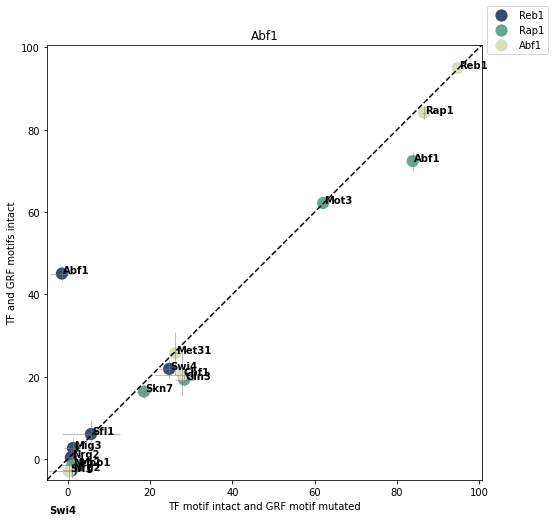

In [36]:
grfs = ['Reb1', 'Rap1', 'Abf1']
tp='180'
thresh=0
col_map = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
col_names = ['TF_wt_GRF_wt', 'TF_wt_GRF_mut','TF_wt_GRF_wt_sem', 'TF_wt_GRF_mut_sem', 'TF', 'GRF', 'Library', 'Library_number']
tfs_grf_df = pd.DataFrame(columns=col_names)   

for grf in grfs: # iterate over GRFs
    tf_files = dp.find_tf_files(grf) # get GRf files
    for file in tf_files: # iterate over files
        _, lib_num, exp_num = file.split('.')[0].split('_') # get library and experiment numbers
        if exp_num=='26': # skip experiment 26
            continue
        grf_pos = lto.get_tf_mot_pos(grf, lib_num) #get grf positions
        norm_df = lto.norm_res_data(grf, lib_num, exp_num, norm_to=0, occ=None) # normlize data - tp0 only
        lib_info = dp.get_lib_info(lib_num)  # get library info
        lib_name = lib_info['gene'] # gene names
        wt_pos = np.array(lib_info['wt_at_var_loc']) # get wt positions
        mut_pos = np.array(list(lto.get_mut_var(lib_num))) # get mutated positions
        # get indices of sequences containing the GRF motifs intact/mutatated
        lib_files = dp.find_lib_files(lib_num) # get all library files
        for tf_file in lib_files: # iterate over library files
            tf, _, tf_exp_num = tf_file.split('.')[0].split('_') # get file tf and experiment number
            if (tf==grf) or (tf=='H3') or (tf_exp_num=='26'): # skip experiment 26
                continue
            tf_norm_df = dp.mean_over_bio_reps(lto.norm_res_data(tf, lib_num, tf_exp_num, norm_to=0, occ=None))  # normlize data - tp0 only
            norm_df_by_tp = tf_norm_df.iloc[:,np.where(tf_norm_df.columns.str.contains(tp))[0][0]] #get only the relevant time point
            lib_seqs = list(norm_df_by_tp.index)
            grf_wt_ids, grf_mut_ids, _, _, _, _ = lto.get_all_tf_motifs_wt_or_mut(grf,lib_info, lib_seqs) 
            tf_pos = lto.get_tf_mot_pos(tf, lib_num) #get tf positions
            tf_pos_wt_ids, _, _, _, _, _ = lto.get_all_tf_motifs_wt_or_mut(tf,lib_info, lib_seqs) # get ids containing the tf positions intact

            
            tf_wt_grf_wt_ids = np.intersect1d(grf_wt_ids,tf_pos_wt_ids) # get ids in which: GRF positions are wt & TF positions are wt
            tf_wt_grf_mut_ids = np.intersect1d(grf_mut_ids,tf_pos_wt_ids)# get ids in which: GRF positions are mut & TF positions are wt
            tf_wt_grf_wt_seqs = np.array(lib_seqs)[tf_wt_grf_wt_ids]
            tf_wt_grf_mut_seqs = np.array(lib_seqs)[tf_wt_grf_mut_ids]

            relevant_pos = np.concatenate([grf_pos, tf_pos]).astype(int)
            norm_seqs_ids_grf_wt = []
            norm_seqs_ids_grf_mut = []
            for seq in tf_wt_grf_wt_seqs:
                temp_seq = np.repeat('x', len(mut_pos))
                temp_seq[np.delete(np.arange(0,len(wt_pos)),relevant_pos)] = np.array(list(seq))[np.delete(np.arange(0,len(wt_pos)),relevant_pos)]
                temp_seq[relevant_pos] = mut_pos[relevant_pos]
                seq_to_norm = ''.join(temp_seq)
                norm_seqs_ids_grf_wt.append(lib_seqs.index(seq_to_norm))

            for seq in tf_wt_grf_mut_seqs:
                temp_seq = np.repeat('x', len(mut_pos))
                temp_seq[np.delete(np.arange(0,len(wt_pos)),relevant_pos)] = np.array(list(seq))[np.delete(np.arange(0,len(wt_pos)),relevant_pos)]
                temp_seq[relevant_pos] = mut_pos[relevant_pos]
                seq_to_norm = ''.join(temp_seq)
                norm_seqs_ids_grf_mut.append(lib_seqs.index(seq_to_norm))

            tf_wt_grf_wt_mean = np.mean(lto.convert_fc_to_occ(norm_df_by_tp[tf_wt_grf_wt_ids].values - norm_df_by_tp[norm_seqs_ids_grf_wt].values) *100)
            tf_wt_grf_mut_mean = np.mean(lto.convert_fc_to_occ(norm_df_by_tp[tf_wt_grf_mut_ids].values - norm_df_by_tp[norm_seqs_ids_grf_mut].values) *100)
            tf_wt_grf_wt_sem = scipy.stats.sem(lto.convert_fc_to_occ(norm_df_by_tp[tf_wt_grf_wt_ids].values - norm_df_by_tp[norm_seqs_ids_grf_wt].values) *100)
            tf_wt_grf_mut_sem = scipy.stats.sem(lto.convert_fc_to_occ(norm_df_by_tp[tf_wt_grf_mut_ids].values - norm_df_by_tp[norm_seqs_ids_grf_mut].values) *100)            
            tfs_grf_df.loc[len(tfs_grf_df.index)] = [tf_wt_grf_wt_mean, tf_wt_grf_mut_mean,tf_wt_grf_wt_sem,
                                                     tf_wt_grf_mut_sem, tf, grf, lib_name, int(lib_num)]
            
lib_color_dict = gf.generate_color_dict(sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=False), np.unique(grfs), 2)

fig,ax = plt.subplots(1,1,figsize=(10,8))

tfs_grf_df.dropna(inplace=True)

for grf_i, grf in enumerate(grfs):
    df_by_grf = tfs_grf_df.loc[tfs_grf_df['GRF']==grf]
    sns.scatterplot(data=df_by_grf, x='TF_wt_GRF_mut', y='TF_wt_GRF_wt', palette=lib_color_dict, hue='GRF', edgecolor="none", s=150, ax=ax) 
    ax.errorbar(df_by_grf['TF_wt_GRF_mut'], df_by_grf['TF_wt_GRF_wt'], xerr=df_by_grf['TF_wt_GRF_mut_sem'], 
                yerr=df_by_grf['TF_wt_GRF_wt_sem'], ecolor='grey',elinewidth=0.5, color='none', fmt='o')
    
    for i in range(len(df_by_grf)):
        line = df_by_grf.iloc[i,:]    
        plt.text(line['TF_wt_GRF_mut']+0.2,line['TF_wt_GRF_wt'], line['TF'], horizontalalignment='left', size='medium', color='black', weight='semibold')

minimum = np.min((ax.get_xlim(),ax.get_ylim()))
maximum = np.max((ax.get_xlim(),ax.get_ylim()))
ax.set_xlim(-5,maximum)
ax.set_ylim(-5,maximum)
ax.set_title(grf)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1.1))
ax.set_xlabel('TF motif intact and GRF motif mutated')
ax.set_ylabel('TF and GRF motifs intact')
plt.axline((0,0),slope=1, c='k', linestyle='--')

for t, l in zip(ax.legend_.texts,grfs):
    t.set_text(l)

ax.set_aspect('equal', 'box')

## (J) GRFs cooperativity scores

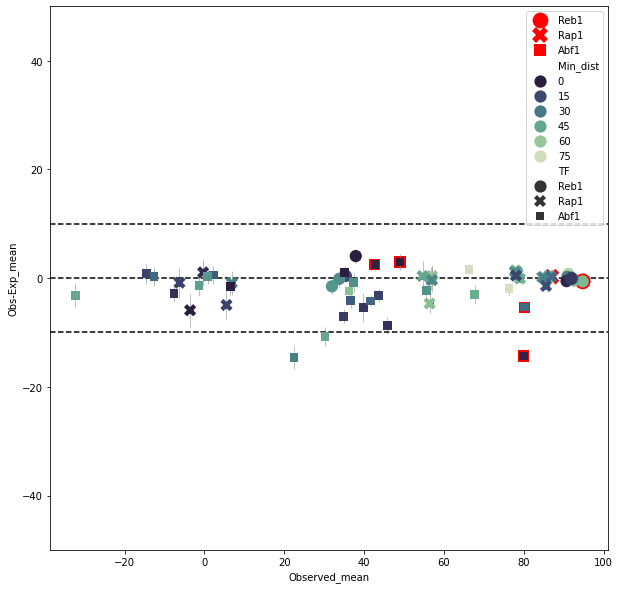

In [28]:
tfs = ['Reb1', 'Rap1', 'Abf1']
exp_nums = ['16','16', '26']
tps = ['180', '180', '210']
col_map = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
col_map_r = matplotlib.colors.ListedColormap(col_map.colors[::-1])

all_tf_mean_df = pd.DataFrame()
for tf_i, tf in enumerate(tfs):
    tf_libs = np.unique([file.split('_')[1] for file in dp.find_tf_files(tf)])
    for lib_num in tf_libs:
        curr_tf_df = lto.obs_exp_mean_context(tf, lib_num, tps[tf_i], [tf], exp_num=exp_nums[tf_i])
        all_tf_mean_df = pd.concat([all_tf_mean_df, curr_tf_df])

fig,ax = plt.subplots(figsize=(10,10))

self_df = all_tf_mean_df.query("Comb_type=='Self_comb'")
sns.scatterplot(data=self_df, x='Observed_mean', y='Obs-Exp_mean', color='r',style='TF', s=250, linewidth=0, ax=ax)


sns.scatterplot(data=all_tf_mean_df, x='Observed_mean', y='Obs-Exp_mean', hue='Min_dist', palette=col_map_r, linewidth=0, style='TF', s=150, zorder=20, ax=ax)
plt.errorbar(all_tf_mean_df['Observed_mean'], all_tf_mean_df['Obs-Exp_mean'], yerr=all_tf_mean_df['Obs-Exp_sem'],ecolor='grey',elinewidth=0.5, fmt='o')

ax.set_ylim(-50,50)
ax.axline((0,0), slope=0, color='k', linestyle='--')
ax.axline((0,10), slope=0, color='k', linestyle='--')
ax.axline((0,-10), slope=0, color='k', linestyle='--')


## (K) Specific examples - Abf1 inhibition, Reb1 no interactions

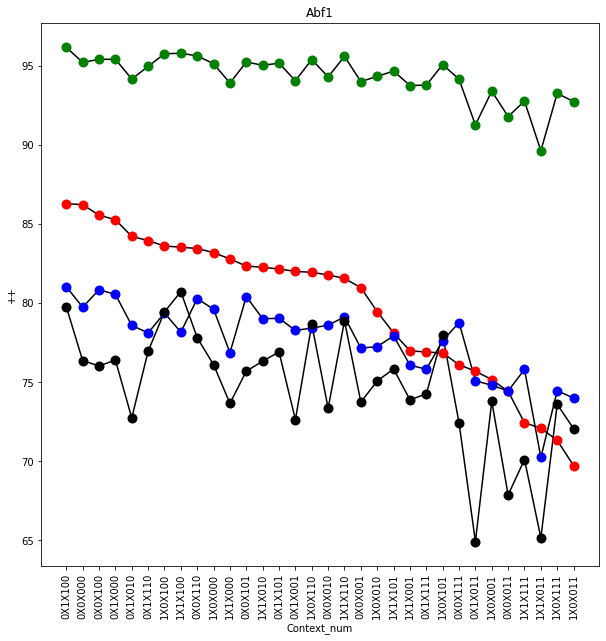

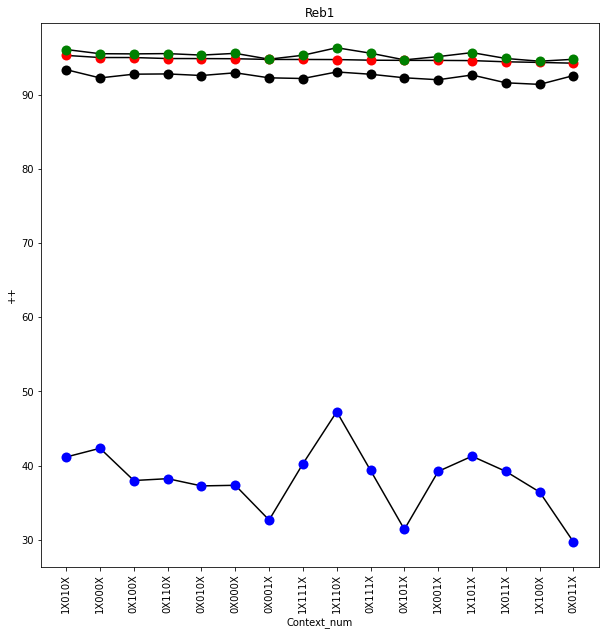

In [29]:
from importlib import reload
reload(lto)

grfs = ['Abf1', 'Reb1']
libs = ['81', '76']
exps = ['26', '16']
combs = [[1,3], [1,5]]
tps = ['210', '180'] 

for grf_i, grf in enumerate(grfs):
    
    lib_num = libs[grf_i]
    exp = exps[grf_i]
    comb = combs[grf_i]
    tp = tps[grf_i]
    
    comb_df = lto.comb_opts_by_context(grf,lib_num,exp, comb, tp)
    
    comb_df_norm = comb_df.iloc[:,0:3] - comb_df.iloc[:,3].to_frame().values
    comb_df_norm['Context'] = comb_df['Context'] 
    comb_df = comb_df_norm
    
    
    comb_df_expected = comb_df.copy()
    comb_df_rel =  comb_df[['++','+-','-+']]
    comb_df_rel = lto.convert_fc_to_occ(comb_df_rel)
    comb_df_rel['Expected'] = 1-((1-comb_df_rel['+-'])*(1-comb_df_rel['-+']))
    comb_df_rel = comb_df_rel*100

    lib_info = dp.get_lib_info(lib_num)
    wt_var_seq = lib_info['wt_at_var_loc']  # get wild-type sequence
    context_nums = []
    for seq in comb_df['Context'].values:
        seq = list(seq)
        seq.insert(comb[0], 'X')
        seq.insert(comb[1], 'X')
        seq = np.array(seq)
        for i,nuc in enumerate(seq):
            if nuc == wt_var_seq[i]:
                seq[i] = '1'
            elif nuc == 'X':
                continue
            else:
                seq[i] = '0'

        context_nums.append(''.join(seq))
    comb_df_rel['Context_num'] = context_nums

    opts_dots = ['++', '+-', '-+','Expected']

    comb_df_rel.sort_values(by='++', ascending=False, inplace=True)
    cols = ['r','b','k','g']
    comb_df_rel.sort_values(by='++')
    comb_df_rel.reset_index(drop=True, inplace=True)
    figure, ax = plt.subplots(1,1,figsize=(10,10))
    axes = []
    for i, opt in enumerate(opts_dots):
        curr_ax = sns.stripplot(data=comb_df_rel, x='Context_num', y=opt, color=cols[i],s=10, ax=ax)
        sns.lineplot(data=comb_df_rel, x=comb_df_rel.index, y=opt, color='k', ax=ax)
        axes.append(curr_ax)
    plt.xticks(rotation = 90)
    ax.set_title(grf)
